In [1]:
from PIL import Image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import tqdm

In [11]:
def reshapeXML(file_path):
    tree = ET.ElementTree(ET.parse(file_path))
    root = tree.getroot()

    objects = {}

    for obj in root.findall('.//object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text
        difficult = obj.find('difficult').text
        
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        if name not in objects:
            objects[name] = []
        save_dict = {
            'pose':pose,
            'truncated':truncated,
            'difficult':difficult,
            'xmin':xmin, 
            'ymin':ymin, 
            'xmax':xmax, 
            'ymax':ymax
        }
        objects[name].append(save_dict)
    return objects

id = "2011_003246"
assert os.path.exists(f"/home/sl237/COMP646_Project/VOCdevkit/VOC2012/Annotations/{id}.xml")
xml = reshapeXML(f'/home/sl237/COMP646_Project/VOCdevkit/VOC2012/Annotations/{id}.xml')
# xml["person"]
print(xml.keys())

dict_keys(['tvmonitor', 'person'])


In [93]:
root = "/home/sl237/COMP646_Project/VOCdevkit/VOC2012"
anno_root = os.path.join(root, "Annotations") 
segob_root = os.path.join(root, "SegmentationObject")
segcls_root = os.path.join(root, "SegmentationClass")
img_root = os.path.join(root, "JPEGImages")

def get_cutout(img, mask, bbox):
    """
    bbox: [xmin, ymin, xmax, ymax]
    """
    
    trans_m = np.array([[1],[1e3], [1e6]])
    bound_c = 192224224
    blank_c = 0
    
    xmin, ymin, xmax, ymax = bbox
    
    mask_trans = (mask @ trans_m).squeeze(-1)
    
    mask_bbox = mask_trans[ymin:ymax, xmin:xmax]
    color_count = np.unique(mask_bbox, return_counts=True)
    color_count = dict(zip(*color_count))
    color_count.pop(blank_c, None)
    if len(color_count.keys()) > 1: color_count.pop(bound_c, None)
    
    sort_counts = sorted(color_count.items(), key=lambda e: e[1], reverse=True)
    color_top = sort_counts[0][0]
    
    mask_target = np.where(mask_trans == color_top)
    
    cutout = np.zeros_like(img)
    cutout[mask_target] = img[mask_target]
    cutout = cutout[ymin:ymax, xmin:xmax]
    return cutout


def get_cutout_global(img, mask, annos=None, perfect=True):
    """
    bbox: [xmin, ymin, xmax, ymax]
    """
    def boundary(inputs):
        col = inputs.shape[1]
        inputs = inputs.reshape(-1)
        lens = len(inputs)
        start = np.argmax(inputs)
        end = lens - 1 - np.argmax(np.flip(inputs))
        top = start // col
        bottom = end // col

        return top, bottom

    def seg_to_box(seg_mask):

        top, bottom = boundary(seg_mask)
        left, right = boundary(seg_mask.T)
        # left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

        return [left, top, right, bottom]
    
    # preprocess annos
    if annos:
        bbox2info = {}
        for clz, instances in annos.items():
            for inst in instances:
                bbox = (inst["xmin"], inst["ymin"], inst["xmax"], inst["ymax"])
                trunc = int(inst["truncated"])
                diffic = int(inst["difficult"])
                bbox2info[bbox] = {"clz":clz, "truncated": trunc, "difficult":diffic}
    
    # convert 3-channel vectors to unique numbers for each color
    trans_m = np.array([[1],[1e3], [1e6]])
    bound_c = 192224224
    blank_c = 0
    
    mask_trans = (mask @ trans_m).squeeze(-1)
    color_count = np.unique(mask_trans, return_counts=True)
    color_count = dict(zip(*color_count))
    color_count.pop(blank_c, None)
    color_count.pop(bound_c, None)
    
    sort_counts = sorted(color_count.items(), key=lambda e: e[1], reverse=True)
    if not len(sort_counts): return
    
    ret_cutouts = []
    for c, num in sort_counts:
        mask_c = np.where(mask_trans == c)
        
        cutout = np.zeros_like(img)
        cutout[mask_c] = img[mask_c]
        
        mask_cutout =  np.zeros_like(mask_trans)
        mask_cutout[mask_c] = 1
        bbox_ = [xmin, ymin, xmax, ymax] = seg_to_box(mask_cutout)
        
        cutout = cutout[ymin:ymax, xmin:xmax]
        # print(bbox_)
        if annos:
            for b, d in bbox2info.items():
                corr = True
                for i in range(len(bbox_)):
                    corr &= abs(bbox_[i] - b[i]) < 15
                if corr:
                    if perfect and d["truncated"] == 0 and d["difficult"] == 0:
                        ret_cutouts.append([d["clz"],cutout])
                    bbox2info.pop(b)
                    break
        else:
            ret_cutouts.append(cutout)
    
    return ret_cutouts



def get_instances(id, use_global=True, perfect=True) -> tuple:
    global anno_root, img_root, segob_root
    
    anno_path = os.path.join(anno_root, f"{id}.xml")
    img_path = os.path.join(img_root, f"{id}.jpg")
    segob_path = os.path.join(segob_root, f"{id}.png")
    
    annos = reshapeXML(anno_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(segob_path), cv2.COLOR_BGR2RGB)
    
    if use_global:
        res = get_cutout_global(img, mask, annos=annos, perfect=perfect)
    else:
        res = []
        for key in annos:
            instances = annos[key]
            for inst in instances:
                bbox = [inst["xmin"], inst["ymin"], inst["xmax"], inst["ymax"]]
                
                if perfect and (int(inst["truncated"]) > 0 or int(inst["difficult"]) > 0 ): continue
                
                try:
                    cutout = get_cutout(img, mask, bbox)
                except:
                    print(f"id {id}, cls {key}, bbox {bbox}")
                    raise
                
                res.append([key, cutout])
    
    return res    


def export_all_instances(output_dir):
    global segob_root
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    ids = list(map(lambda f: os.path.splitext(f)[0], os.listdir(segob_root)))
    bar = tqdm.tqdm(total=len(ids))
    for id in ids:
        res = get_instances(id)
        for i, data in enumerate(res):
            clz, img = data
            
            output_name = f"{id}_{clz}_{i}.png"
            output_path = os.path.join(output_dir, output_name)
            
            cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        bar.update()


In [91]:
output_dir = f"/home/rz60/codes/COMP646/COMP646_Project/segments_pool"
export_all_instances(output_dir)

100%|██████████| 2913/2913 [01:14<00:00, 38.97it/s]


In [ ]:
a = get_instances("2007_000033")

n = 2
plt.imshow(a[n][1])
cv2.imwrite("./test.png", a[n][1])
cv2.imwrite("./test2.png", cv2.cvtColor(a[n][1], cv2.COLOR_RGB2BGR))


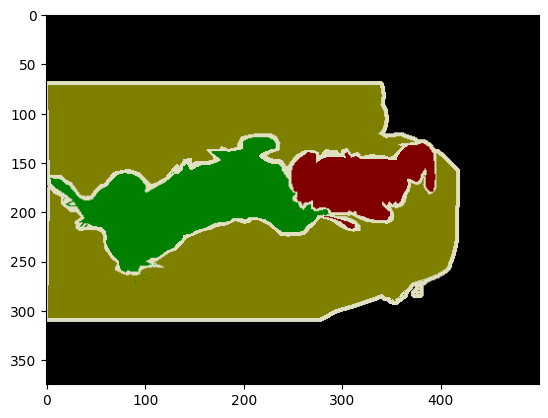

In [84]:
def imshow(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
id = "2011_003256"
imshow(os.path.join(segob_root, f"{id}.png"))
# imshow(os.path.join(img_root, "2007_000033.jpg"))
# imshow(os.path.join(segcls_root, "2011_003246.png"))
# os.path.exists(os.path.join(segob_root, "2008_002255.png"))

In [23]:
a = {"a":1}
len(a)

1

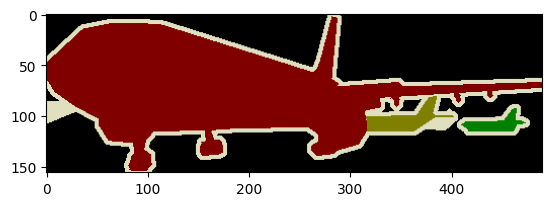

In [29]:
x_min, x_max, y_min, y_max = 9, 499, 107, 263

img = cv2.imread(os.path.join(segob_root, "2007_000033.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ob1 = img[y_min:y_max, x_min:x_max]
plt.imshow(ob1)
plt.show()

In [88]:
def imload(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

id = "2011_003256"
mask = imload(os.path.join(segob_root, f"{id}.png"))
img = imload(os.path.join(img_root, f"{id}.jpg"))
annos = reshapeXML(os.path.join(anno_root, f"{id}.xml"))
print(annos)
cutouts = get_cutout_global(img, mask, annos=annos)
print(len(cutouts))

{'dog': [{'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'xmin': 246, 'ymin': 130, 'xmax': 398, 'ymax': 218}, {'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'xmin': 5, 'ymin': 124, 'xmax': 287, 'ymax': 265}], 'sofa': [{'pose': 'Unspecified', 'truncated': '1', 'difficult': '0', 'xmin': 5, 'ymin': 75, 'xmax': 414, 'ymax': 307}]}
2


dog


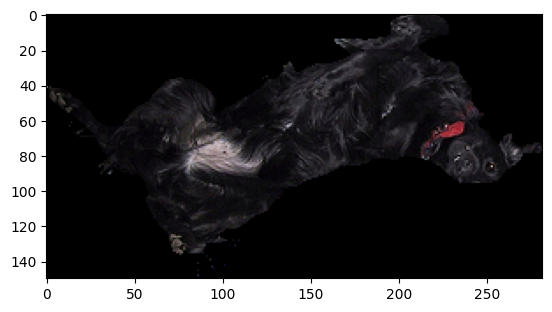

In [89]:
cutout = cutouts[0]
print(cutout[0])
plt.imshow(cutout[1])
